# SCRIPT TO OBTAIN PHENOTIPIC QUANTITAVE TREATS FOR OPIOIDS (LOPERAMIDE, MORPHINE, MORPHINE+CODEINE AND FENTANYL)

Quantitave traits: 
- Number of drug eras 
- Total drug exposures
- Treatment duration
- Cumulative gaps days

The participants with no data on this fields: NA


## This script should only be run once

#### Initialization
##### Load packages

In [3]:
import pyspark
import dxpy
import dxdata
from pyspark.sql.functions import col, to_date, lower

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

##### Spark and dataset configuration 

In [ ]:
# Load the table
df = pd.read_csv("drug_era_atc.tsv", sep="\t")

# List of drugs to filter
drugs_to_filter = ["loperamide", "fentanyl", "morphine", "codeine"]

# Filter rows where the drug name is in the list of drugs to filter
filtered_df = df[df["concept_name"].isin(drugs_to_filter)]

# Select the required columns and rename _c13 to ATC
filtered_df = filtered_df[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df.rename(columns={"_c13": "ATC"}, inplace=True)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03
1354,1201620,codeine,Drug,Ingredient,2670,1970-01-01,2099-12-31,NaN,R05DA04
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01


In [ ]:
# Import the ATC dictionaries from atc_dict.py
from atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df["ATC_First_Level"] = filtered_df["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df["ATC_Second_Level"] = filtered_df["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df["First_Level_Name"] = filtered_df["ATC_First_Level"].map(atc_1st_level)
filtered_df["Second_Level_Name"] = filtered_df["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01,N,N01,Nervous System,Anesthetics
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03,N,N02,Nervous System,Analgesics
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."
1354,1201620,codeine,Drug,Ingredient,2670,1970-01-01,2099-12-31,NaN,R05DA04,R,R05,Respiratory System,Cough and Cold Preparations
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01,N,N02,Nervous System,Analgesics


In [8]:
# Save the filtered table to a new file
filtered_df.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

In [9]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [10]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era'
omop_drug_era = "omop_drug_era"

# Load table
drug_era = dataset[omop_drug_era]

# Extract all field names from the table
field_names_era = [f.name for f in drug_era.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())

print(df_era.columns)

print(f"Number of entries era {df_era.count()}")
df_era.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
Number of entries era 19959413
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|1236950609195|19005129       |12/05/2014         |10/06/2014       |1                  |0       |
|798863919105 |743670         |30/03/2011         |02/09/2011       |5                  |12      |
|721554547993 |19008994       |12/10/2010         |07/11/2010       |1                  |0       |
+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showing top 3 rows



In [11]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[1154029, 991876, 1201620, 1110410]

In [12]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", to_date(col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", to_date(col("drug_era_end_date"), "dd/MM/yyyy"))

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|523986031867 |1201620        |2005-01-04         |2005-02-02       |1                  |0       |
|704374697810 |1201620        |2008-07-29         |2008-10-17       |2                  |22      |
|575525667834 |1201620        |2015-05-28         |2015-06-26       |1                  |0       |
|781684097755 |1201620        |2009-12-24         |2010-01-07       |1                  |0       |
|300647715760 |1201620        |1999-05-04         |1999-06-02       |1                  |0       |
|111669178968 |1201620        |1994-04-25         |1994-10-14       |6                  |15      |
|884763309279 |1201620        |2006-04-27         |2006-05-26       |2                  |0       |
|584115553

479021

In [13]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_df_era = filtered_df_era.toPandas()
pandas_df_era.loc[:, "drug_concept_id"] = pandas_df_era.loc[
    :, "drug_concept_id"
].astype(int)
# Merge pandas_df_era with drug_mapping_df on `drug_concept_id`
pandas_df_era = pandas_df_era.merge(
    drug_mapping_df[["drug_concept_id", "concept_name"]],  # Only keep necessary columns
    on="drug_concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'drug'
pandas_df_era.rename(columns={"concept_name": "drug"}, inplace=True)

# Save the Pandas DataFrame to a CSV file
pandas_df_era.to_csv("filtered_data_era.csv", index=False)

In [14]:
display(pandas_df_era.drop("eid", axis=1))

,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug
0,523986031867,1201620,2005-01-04,2005-02-02,1,0,codeine
1,704374697810,1201620,2008-07-29,2008-10-17,2,22,codeine
2,575525667834,1201620,2015-05-28,2015-06-26,1,0,codeine
3,781684097755,1201620,2009-12-24,2010-01-07,1,0,codeine
4,300647715760,1201620,1999-05-04,1999-06-02,1,0,codeine
...,...,...,...,...,...,...,...
482143,1176821060325,1201620,2011-11-02,2011-12-01,2,0,codeine
482144,627065239877,1201620,2015-03-13,2015-04-11,1,0,codeine
482145,910533081555,1201620,2008-04-22,2008-05-21,1,0,codeine
482146,438086665084,1110410,2015-02-03,2015-12-05,12,116,morphine


In [15]:
# Load the CSV file as a DataFrame
data = pd.read_csv("filtered_data_era.csv")

Start with only morphine

In [16]:
data_morphine = data[data["drug"] == "morphine"]

In [17]:
data_morphine_sorted = data_morphine.sort_values(by="drug_era_start_date")
morphine_eras = (
    data_morphine_sorted.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(morphine_eras.drop("eid", axis=1))

,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,1,[2013-02-06],[2013-03-12],[2],[0]
1,1,[2008-07-31],[2008-08-11],[1],[0]
2,1,[2013-04-08],[2014-04-05],[51],[37]
3,1,[2015-05-07],[2015-06-16],[4],[0]
4,1,[2015-09-11],[2015-10-17],[2],[0]
...,...,...,...,...,...
7212,4,"[2013-03-01, 2013-12-12, 2014-09-22, 2015-01-30]","[2013-03-30, 2014-01-10, 2014-10-21, 2015-06-26]","[1, 1, 2, 10]","[0, 0, 7, 27]"
7213,2,"[2010-05-14, 2013-01-15]","[2010-09-11, 2013-02-13]","[4, 1]","[19, 0]"
7214,1,[2003-08-05],[2003-10-24],[3],[7]
7215,1,[2013-11-25],[2016-07-12],[49],[253]


In [ ]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(morphine_eras["num_drug_era_id"].describe())

# Total exposures per participant
morphine_eras["total_exposure_counts"] = morphine_eras["exposure_counts"].apply(sum)
# Analyze total exposure counts
print("\nSummary of total exposure:")
print(morphine_eras["total_exposure_counts"].describe())

# Convert dates to datetime
morphine_eras["start_dates_parsed"] = morphine_eras["start_dates"].apply(
    lambda x: pd.to_datetime(x)
)
morphine_eras["end_dates_parsed"] = morphine_eras["end_dates"].apply(
    lambda x: pd.to_datetime(x)
)
# Calculate total_duration
morphine_eras["total_duration"] = morphine_eras.apply(
    lambda row: (max(row["end_dates_parsed"]) - min(row["start_dates_parsed"])).days,
    axis=1,
)
print("Summary of total_duration:")
print(morphine_eras["total_duration"].describe())

# Calculate duration_era
morphine_eras["duration_era"] = morphine_eras.apply(
    lambda row: [
        (end - start).days
        for start, end in zip(row["start_dates_parsed"], row["end_dates_parsed"])
    ],
    axis=1,
)

# Calculate gap_between_eras
morphine_eras["gap_between_eras"] = morphine_eras.apply(
    lambda row: [
        (next_start - prev_end).days
        for prev_end, next_start in zip(
            row["end_dates_parsed"][:-1], row["start_dates_parsed"][1:]
        )
    ],
    axis=1,
)

# Calculate cumulative gap days (sum of all gaps between exposures and between eras)
morphine_eras["cumulative_gap_days"] = morphine_eras.apply(
    lambda row: sum(row["gap_days"]) + sum(row["gap_between_eras"])
    if isinstance(row["gap_days"], list) and isinstance(row["gap_between_eras"], list)
    else 0,
    axis=1,
)
print("\nSummary of cumulative_gap_days:")
print(morphine_eras["cumulative_gap_days"].describe())

display(morphine_eras.drop("eid", axis=1))

Summary of num_drug_era_id:
count    7217.000000
mean        2.077872
std         3.451562
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        80.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    7217.000000
mean       15.735901
std        44.949850
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max      1004.000000
Name: total_exposure_counts, dtype: float64
Summary of total_duration:
count    7217.000000
mean      476.932520
std       981.655779
min         0.000000
25%        29.000000
50%        56.000000
75%       363.000000
max      9621.000000
Name: total_duration, dtype: float64

Summary of cumulative_gap_days:
count    7217.000000
mean      271.309131
std       692.932995
min         0.000000
25%         0.000000
50%         0.000000
75%       140.000000
max      8084.000000
Name: cumulative_gap_days, dtype: float64


,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,total_duration,duration_era,gap_between_eras,cumulative_gap_days
0,1,[2013-02-06],[2013-03-12],[2],[0],2,"DatetimeIndex(['2013-02-06'], dtype='datetime6...","DatetimeIndex(['2013-03-12'], dtype='datetime6...",34,[34],[],0
1,1,[2008-07-31],[2008-08-11],[1],[0],1,"DatetimeIndex(['2008-07-31'], dtype='datetime6...","DatetimeIndex(['2008-08-11'], dtype='datetime6...",11,[11],[],0
2,1,[2013-04-08],[2014-04-05],[51],[37],51,"DatetimeIndex(['2013-04-08'], dtype='datetime6...","DatetimeIndex(['2014-04-05'], dtype='datetime6...",362,[362],[],37
3,1,[2015-05-07],[2015-06-16],[4],[0],4,"DatetimeIndex(['2015-05-07'], dtype='datetime6...","DatetimeIndex(['2015-06-16'], dtype='datetime6...",40,[40],[],0
4,1,[2015-09-11],[2015-10-17],[2],[0],2,"DatetimeIndex(['2015-09-11'], dtype='datetime6...","DatetimeIndex(['2015-10-17'], dtype='datetime6...",36,[36],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...
7212,4,"[2013-03-01, 2013-12-12, 2014-09-22, 2015-01-30]","[2013-03-30, 2014-01-10, 2014-10-21, 2015-06-26]","[1, 1, 2, 10]","[0, 0, 7, 27]",14,"DatetimeIndex(['2013-03-01', '2013-12-12', '20...","DatetimeIndex(['2013-03-30', '2014-01-10', '20...",847,"[29, 29, 29, 147]","[257, 255, 101]",647
7213,2,"[2010-05-14, 2013-01-15]","[2010-09-11, 2013-02-13]","[4, 1]","[19, 0]",5,"DatetimeIndex(['2010-05-14', '2013-01-15'], dt...","DatetimeIndex(['2010-09-11', '2013-02-13'], dt...",1006,"[120, 29]",[857],876
7214,1,[2003-08-05],[2003-10-24],[3],[7],3,"DatetimeIndex(['2003-08-05'], dtype='datetime6...","DatetimeIndex(['2003-10-24'], dtype='datetime6...",80,[80],[],7
7215,1,[2013-11-25],[2016-07-12],[49],[253],49,"DatetimeIndex(['2013-11-25'], dtype='datetime6...","DatetimeIndex(['2016-07-12'], dtype='datetime6...",960,[960],[],253


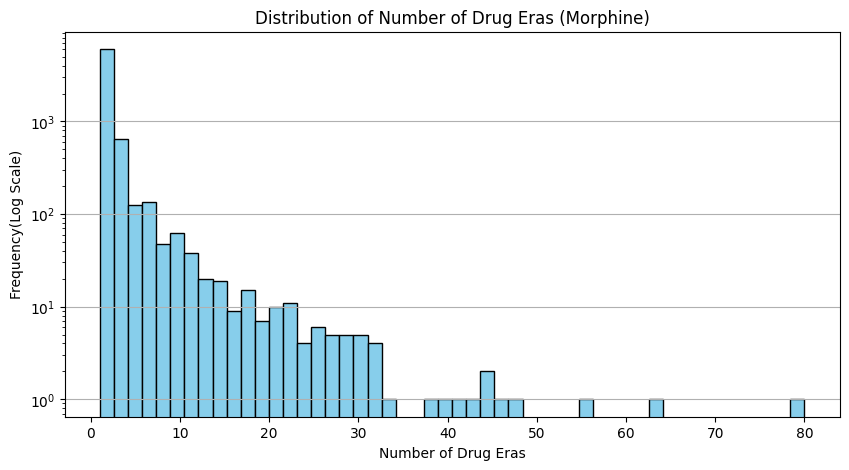

In [19]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras["num_drug_era_id"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (Morphine)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

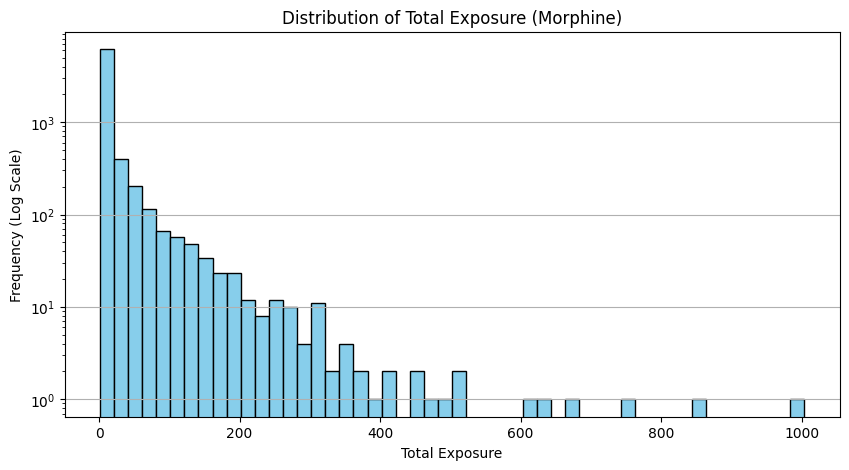

In [20]:
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (Morphine)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
plt.show()

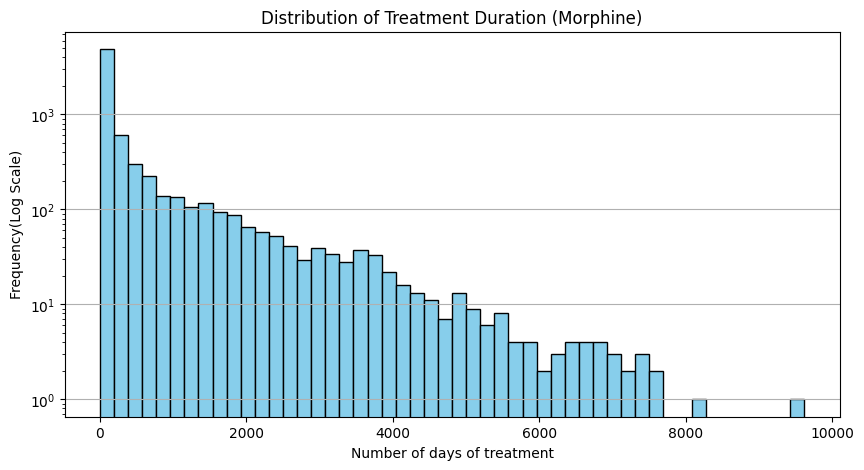

In [21]:
# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras["total_duration"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Treatment Duration (Morphine)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

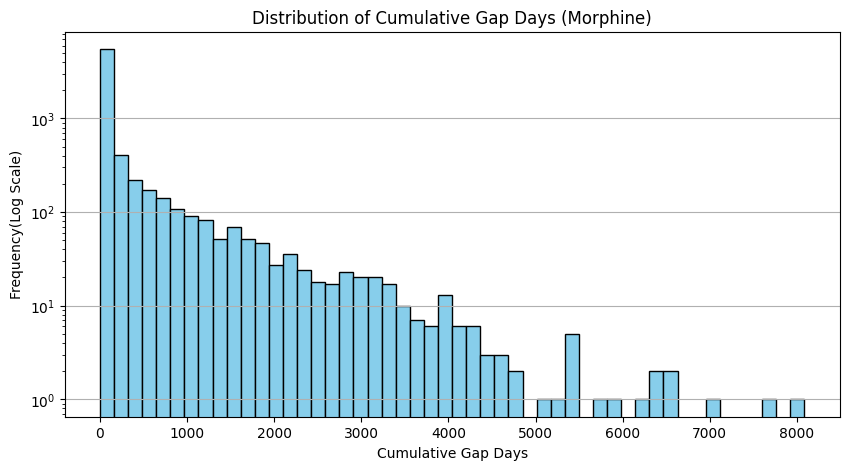

In [22]:
# Visualize cumulative gap days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras["cumulative_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Cumulative Gap Days (Morphine)")
plt.xlabel("Cumulative Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

In [23]:
morphine_eras.to_csv("omop_morphine_groupbyeid.csv", index=False)

Continue with only loperamide

In [24]:
data_loperamide = data[data["drug"] == "loperamide"]

In [25]:
data_loperamide_sorted = data_loperamide.sort_values(by="drug_era_start_date")
loperamide_eras = (
    data_loperamide_sorted.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(loperamide_eras.drop("eid", axis=1))

,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,1,[2013-05-07],[2013-05-09],[1],[0]
1,1,[2002-03-25],[2002-04-03],[1],[0]
2,1,[2008-12-24],[2009-01-22],[1],[0]
3,1,[2012-04-13],[2012-06-13],[2],[3]
4,1,[2013-07-08],[2013-07-13],[1],[0]
...,...,...,...,...,...
15655,2,"[1998-11-02, 2001-05-29]","[1998-11-07, 2001-05-31]","[1, 1]","[0, 0]"
15656,1,[2012-08-16],[2012-08-18],[1],[0]
15657,2,"[1997-09-29, 2002-09-30]","[1997-10-04, 2002-10-05]","[1, 1]","[0, 0]"
15658,1,[2006-03-24],[2006-03-27],[1],[0]


In [ ]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(loperamide_eras["num_drug_era_id"].describe())

# Total exposures per participant
loperamide_eras["total_exposure_counts"] = loperamide_eras["exposure_counts"].apply(sum)
# Analyze total exposure counts
print("\nSummary of total exposure:")
print(loperamide_eras["total_exposure_counts"].describe())

# Convert dates to datetime
loperamide_eras["start_dates_parsed"] = loperamide_eras["start_dates"].apply(
    lambda x: pd.to_datetime(x)
)
loperamide_eras["end_dates_parsed"] = loperamide_eras["end_dates"].apply(
    lambda x: pd.to_datetime(x)
)
# Calculate total_duration
loperamide_eras["total_duration"] = loperamide_eras.apply(
    lambda row: (max(row["end_dates_parsed"]) - min(row["start_dates_parsed"])).days,
    axis=1,
)
print("Summary of total_duration:")
print(loperamide_eras["total_duration"].describe())

# Calculate duration_era
loperamide_eras["duration_era"] = loperamide_eras.apply(
    lambda row: [
        (end - start).days
        for start, end in zip(row["start_dates_parsed"], row["end_dates_parsed"])
    ],
    axis=1,
)

# Calculate gap_between_eras
loperamide_eras["gap_between_eras"] = loperamide_eras.apply(
    lambda row: [
        (next_start - prev_end).days
        for prev_end, next_start in zip(
            row["end_dates_parsed"][:-1], row["start_dates_parsed"][1:]
        )
    ],
    axis=1,
)

# Calculate cumulative gap days (sum of all gaps between exposures and between eras)
loperamide_eras["cumulative_gap_days"] = loperamide_eras.apply(
    lambda row: sum(row["gap_days"]) + sum(row["gap_between_eras"])
    if isinstance(row["gap_days"], list) and isinstance(row["gap_between_eras"], list)
    else 0,
    axis=1,
)
print("\nSummary of cumulative_gap_days:")
print(loperamide_eras["cumulative_gap_days"].describe())

display(loperamide_eras.drop("eid", axis=1))

Summary of num_drug_era_id:
count    15660.000000
mean         3.456705
std          7.184902
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        103.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    15660.000000
mean         6.803384
std         19.541310
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        420.000000
Name: total_exposure_counts, dtype: float64
Summary of total_duration:
count    15660.000000
mean       732.875862
std       1511.599718
min          0.000000
25%          5.000000
50%         11.000000
75%        610.250000
max      10035.000000
Name: total_duration, dtype: float64

Summary of cumulative_gap_days:
count    15660.000000
mean       632.086143
std       1345.761220
min          0.000000
25%          0.000000
50%          0.000000
75%        496.000000
max       9093.000000
Name: cumulative_gap_days, dtype: float64


,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,total_duration,duration_era,gap_between_eras,cumulative_gap_days
0,1,[2013-05-07],[2013-05-09],[1],[0],1,"DatetimeIndex(['2013-05-07'], dtype='datetime6...","DatetimeIndex(['2013-05-09'], dtype='datetime6...",2,[2],[],0
1,1,[2002-03-25],[2002-04-03],[1],[0],1,"DatetimeIndex(['2002-03-25'], dtype='datetime6...","DatetimeIndex(['2002-04-03'], dtype='datetime6...",9,[9],[],0
2,1,[2008-12-24],[2009-01-22],[1],[0],1,"DatetimeIndex(['2008-12-24'], dtype='datetime6...","DatetimeIndex(['2009-01-22'], dtype='datetime6...",29,[29],[],0
3,1,[2012-04-13],[2012-06-13],[2],[3],2,"DatetimeIndex(['2012-04-13'], dtype='datetime6...","DatetimeIndex(['2012-06-13'], dtype='datetime6...",61,[61],[],3
4,1,[2013-07-08],[2013-07-13],[1],[0],1,"DatetimeIndex(['2013-07-08'], dtype='datetime6...","DatetimeIndex(['2013-07-13'], dtype='datetime6...",5,[5],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...
15655,2,"[1998-11-02, 2001-05-29]","[1998-11-07, 2001-05-31]","[1, 1]","[0, 0]",2,"DatetimeIndex(['1998-11-02', '2001-05-29'], dt...","DatetimeIndex(['1998-11-07', '2001-05-31'], dt...",941,"[5, 2]",[934],934
15656,1,[2012-08-16],[2012-08-18],[1],[0],1,"DatetimeIndex(['2012-08-16'], dtype='datetime6...","DatetimeIndex(['2012-08-18'], dtype='datetime6...",2,[2],[],0
15657,2,"[1997-09-29, 2002-09-30]","[1997-10-04, 2002-10-05]","[1, 1]","[0, 0]",2,"DatetimeIndex(['1997-09-29', '2002-09-30'], dt...","DatetimeIndex(['1997-10-04', '2002-10-05'], dt...",1832,"[5, 5]",[1822],1822
15658,1,[2006-03-24],[2006-03-27],[1],[0],1,"DatetimeIndex(['2006-03-24'], dtype='datetime6...","DatetimeIndex(['2006-03-27'], dtype='datetime6...",3,[3],[],0


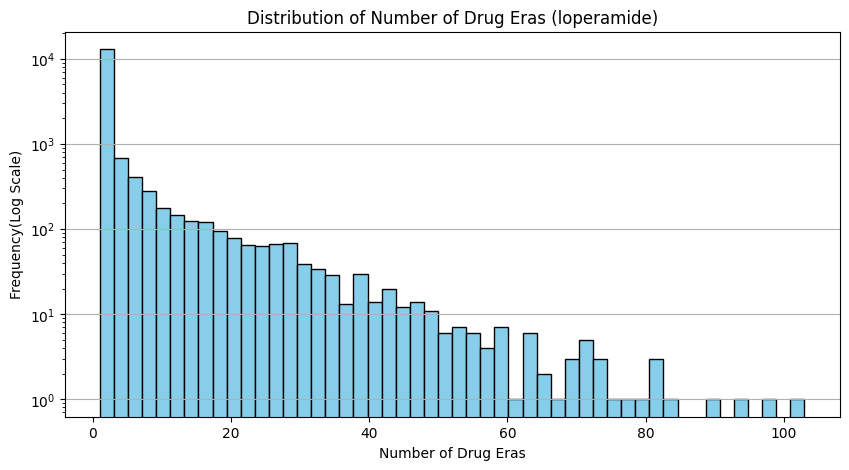

In [27]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras["num_drug_era_id"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (loperamide)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

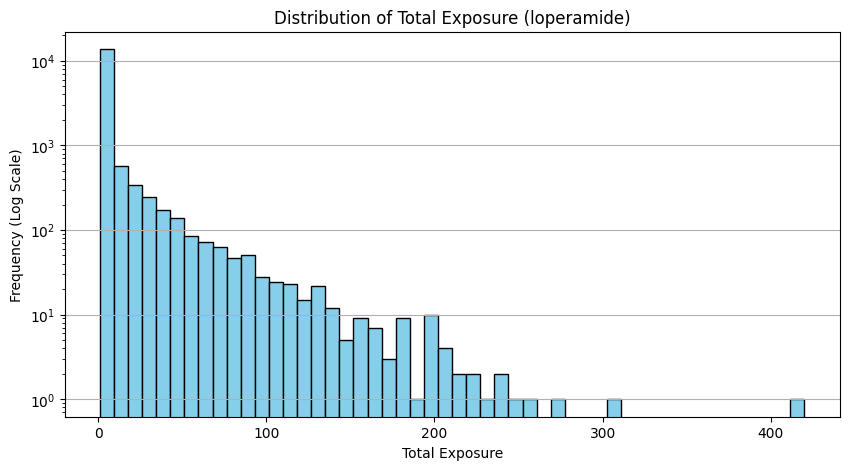

In [28]:
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (loperamide)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
plt.show()

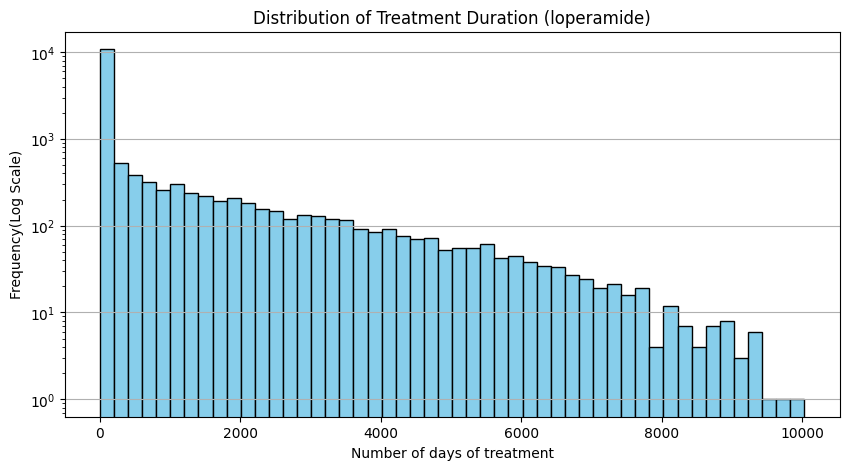

In [29]:
# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras["total_duration"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Treatment Duration (loperamide)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

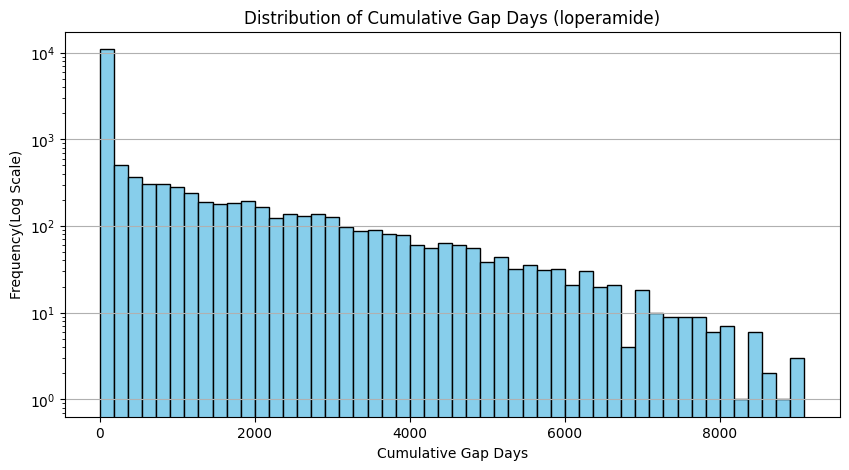

In [30]:
# Visualize cumulative gap days
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras["cumulative_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Cumulative Gap Days (loperamide)")
plt.xlabel("Cumulative Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

In [31]:
loperamide_eras.to_csv("omop_loperamide_groupbyeid.csv", index=False)

Now for both morphine + codeine

In [32]:
data_morphine_codeine = data[(data["drug"] == "morphine") | (data["drug"] == "codeine")]

In [ ]:
data_morphine_codeine_sorted = data_morphine_codeine.sort_values(
    by="drug_era_start_date"
)
morphine_codeine_eras = (
    data_morphine_codeine_sorted.groupby("eid")
    .agg(
        drugs=("drug", list),
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(morphine_codeine_eras.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0]
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]"
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]"
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]"
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]"
...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]"
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]"
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]"


In [ ]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(morphine_codeine_eras["num_drug_era_id"].describe())

# Total exposures per participant
morphine_codeine_eras["total_exposure_counts"] = morphine_codeine_eras[
    "exposure_counts"
].apply(sum)
# Analyze total exposure counts
print("\nSummary of total exposure:")
print(morphine_codeine_eras["total_exposure_counts"].describe())

# Convert dates to datetime
morphine_codeine_eras["start_dates_parsed"] = morphine_codeine_eras[
    "start_dates"
].apply(lambda x: pd.to_datetime(x))
morphine_codeine_eras["end_dates_parsed"] = morphine_codeine_eras["end_dates"].apply(
    lambda x: pd.to_datetime(x)
)
# Calculate total_duration
morphine_codeine_eras["total_duration"] = morphine_codeine_eras.apply(
    lambda row: (max(row["end_dates_parsed"]) - min(row["start_dates_parsed"])).days,
    axis=1,
)
print("Summary of total_duration:")
print(morphine_codeine_eras["total_duration"].describe())

# Calculate duration_era
morphine_codeine_eras["duration_era"] = morphine_codeine_eras.apply(
    lambda row: [
        (end - start).days
        for start, end in zip(row["start_dates_parsed"], row["end_dates_parsed"])
    ],
    axis=1,
)

# Calculate gap_between_eras
morphine_codeine_eras["gap_between_eras"] = morphine_codeine_eras.apply(
    lambda row: [
        max((next_start - prev_end).days, 0)
        for prev_end, next_start in zip(
            row["end_dates_parsed"][:-1], row["start_dates_parsed"][1:]
        )
    ],
    axis=1,
)

# Calculate cumulative gap days (sum of all gaps between exposures and between eras)
morphine_codeine_eras["cumulative_gap_days"] = morphine_codeine_eras.apply(
    lambda row: sum(row["gap_days"]) + sum(row["gap_between_eras"])
    if isinstance(row["gap_days"], list) and isinstance(row["gap_between_eras"], list)
    else 0,
    axis=1,
)
print("\nSummary of cumulative_gap_days:")
print(morphine_codeine_eras["cumulative_gap_days"].describe())

display(morphine_codeine_eras.drop("eid", axis=1))

Summary of num_drug_era_id:
count    103449.000000
mean          4.077004
std           5.802804
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          99.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    103449.000000
mean         11.705159
std          29.789345
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max        1015.000000
Name: total_exposure_counts, dtype: float64
Summary of total_duration:
count    103449.000000
mean       1729.071214
std        2164.401467
min           0.000000
25%          29.000000
50%         664.000000
75%        3027.000000
max       10103.000000
Name: total_duration, dtype: float64

Summary of cumulative_gap_days:
count    103449.000000
mean       1457.164236
std        1924.315598
min           0.000000
25%           0.000000
50%         461.000000
75%        2519.000000
max        9985.000000
Name: cumulative_gap_days, dt

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,total_duration,duration_era,gap_between_eras,cumulative_gap_days
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8,[8],[],0
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",331,"[29, 29]",[273],273
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",779,"[80, 33, 8]","[52, 606]",658
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",504,"[29, 30, 29, 29, 29, 29]","[78, 66, 57, 59, 69]",329
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",2381,"[4, 29, 29]","[1361, 958]",2319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",4544,"[29, 46, 29, 29, 84, 29, 29]","[952, 323, 2568, 250, 56, 120]",4295
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",1811,"[117, 29, 129, 29, 29, 29, 29, 29, 29, 29]","[72, 105, 229, 427, 195, 132, 49, 79, 45]",1396
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",5833,"[29, 29, 29, 29, 29]","[2015, 97, 1833, 1743]",5688
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",5402,"[29, 29, 159, 29, 82, 252, 70, 29]","[1322, 1158, 64, 171, 445, 1308, 255]",4836


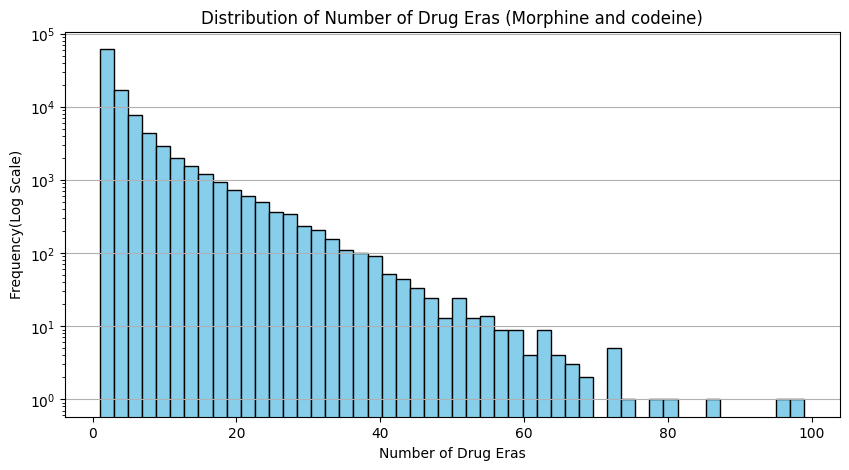

In [42]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_eras["num_drug_era_id"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (Morphine and codeine)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

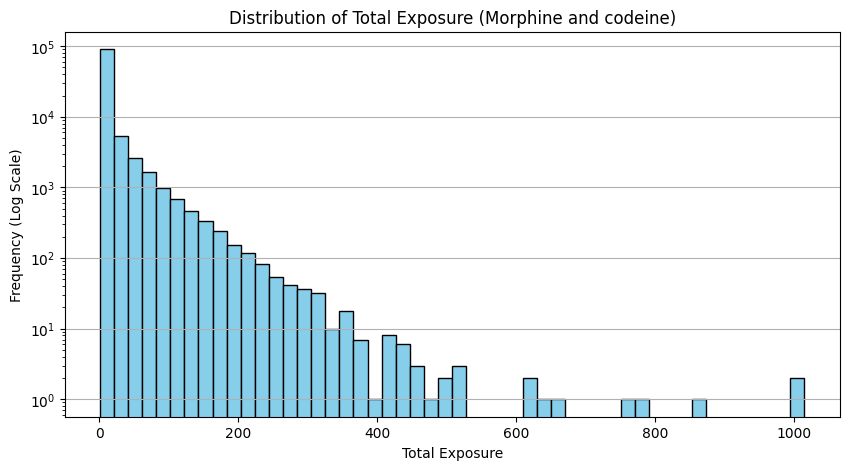

In [43]:
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_eras["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (Morphine and codeine)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
plt.show()

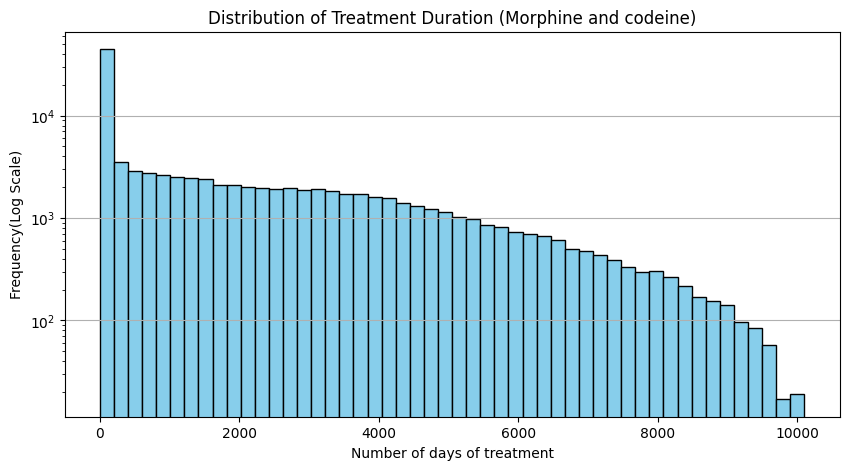

In [44]:
# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_eras["total_duration"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Treatment Duration (Morphine and codeine)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

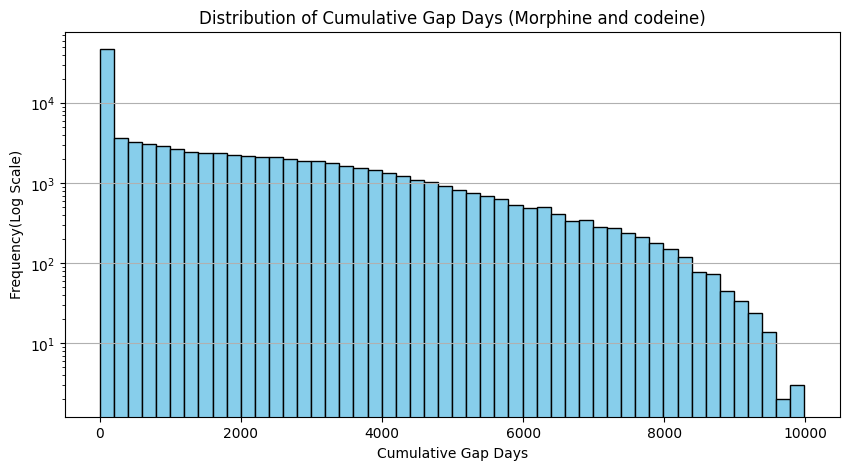

In [45]:
# Visualize cumulative gap days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_eras["cumulative_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Cumulative Gap Days (Morphine and codeine)")
plt.xlabel("Cumulative Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

In [46]:
morphine_codeine_eras.to_csv("omop_morphine_codeine_groupbyeid.csv", index=False)

Continue with fentanyl

In [ ]:
data_fentanyl = data[data["drug"] == "fentanyl"]

In [ ]:
data_fentanyl_sorted = data_fentanyl.sort_values(by="drug_era_start_date")
fentanyl_eras = (
    data_fentanyl_sorted.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(fentanyl_eras.drop("eid", axis=1))

,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,1,"[2015-09-22, 2015-09-22]","[2016-05-14, 2016-05-14]","[16, 16]","[1, 1]"
1,1,"[2015-10-02, 2015-10-02]","[2015-10-31, 2015-10-31]","[1, 1]","[0, 0]"
2,1,"[2010-06-07, 2010-06-07]","[2010-07-20, 2010-07-20]","[2, 2]","[0, 0]"
3,1,"[2014-12-03, 2014-12-03]","[2015-01-01, 2015-01-01]","[1, 1]","[0, 0]"
4,2,"[2016-05-16, 2016-05-16, 2017-03-22, 2017-03-22]","[2016-07-26, 2016-07-26, 2017-04-20, 2017-04-20]","[8, 8, 2, 2]","[0, 0, 0, 0]"
...,...,...,...,...,...
1679,1,"[2011-08-09, 2011-08-09]","[2011-10-05, 2011-10-05]","[3, 3]","[0, 0]"
1680,3,"[2011-06-02, 2011-06-02, 2013-10-08, 2013-10-0...","[2011-07-08, 2011-07-08, 2014-01-17, 2014-01-1...","[3, 3, 5, 5, 2, 2]","[0, 0, 0, 0, 0, 0]"
1681,1,"[2011-03-10, 2011-03-10]","[2011-07-20, 2011-07-20]","[5, 5]","[33, 33]"
1682,1,"[2006-09-18, 2006-09-18]","[2007-01-13, 2007-01-13]","[5, 5]","[2, 2]"


In [ ]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(fentanyl_eras["num_drug_era_id"].describe())

# Total exposures per participant
fentanyl_eras["total_exposure_counts"] = fentanyl_eras["exposure_counts"].apply(sum)
# Analyze total exposure counts
print("\nSummary of total exposure:")
print(fentanyl_eras["total_exposure_counts"].describe())

# Convert dates to datetime
fentanyl_eras["start_dates_parsed"] = fentanyl_eras["start_dates"].apply(
    lambda x: pd.to_datetime(x)
)
fentanyl_eras["end_dates_parsed"] = fentanyl_eras["end_dates"].apply(
    lambda x: pd.to_datetime(x)
)
# Calculate total_duration
fentanyl_eras["total_duration"] = fentanyl_eras.apply(
    lambda row: (max(row["end_dates_parsed"]) - min(row["start_dates_parsed"])).days,
    axis=1,
)
print("Summary of total_duration:")
print(fentanyl_eras["total_duration"].describe())

# Calculate duration_era
fentanyl_eras["duration_era"] = fentanyl_eras.apply(
    lambda row: [
        (end - start).days
        for start, end in zip(row["start_dates_parsed"], row["end_dates_parsed"])
    ],
    axis=1,
)

# Calculate gap_between_eras
fentanyl_eras["gap_between_eras"] = fentanyl_eras.apply(
    lambda row: [
        (next_start - prev_end).days
        for prev_end, next_start in zip(
            row["end_dates_parsed"][:-1], row["start_dates_parsed"][1:]
        )
    ],
    axis=1,
)

# Calculate cumulative gap days (sum of all gaps between exposures and between eras)
fentanyl_eras["cumulative_gap_days"] = fentanyl_eras.apply(
    lambda row: sum(row["gap_days"]) + sum(row["gap_between_eras"])
    if isinstance(row["gap_days"], list) and isinstance(row["gap_between_eras"], list)
    else 0,
    axis=1,
)
print("\nSummary of cumulative_gap_days:")
print(fentanyl_eras["cumulative_gap_days"].describe())

display(fentanyl_eras.drop("eid", axis=1))

Summary of num_drug_era_id:
count    1684.000000
mean        1.856888
std         2.549860
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        26.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    1684.000000
mean       43.876485
std        82.985407
min         2.000000
25%         4.000000
50%        10.000000
75%        38.500000
max       806.000000
Name: total_exposure_counts, dtype: float64
Summary of total_duration:
count    1684.000000
mean      592.172803
std      1027.376617
min        29.000000
25%        29.000000
50%       106.500000
75%       601.250000
max      6763.000000
Name: total_duration, dtype: float64

Summary of cumulative_gap_days:
count    1684.000000
mean     -264.684679
std       719.915799
min     -5555.000000
25%      -236.250000
50%       -56.000000
75%       -29.000000
max      4505.000000
Name: cumulative_gap_days, dtype: float64


,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,total_duration,duration_era,gap_between_eras,cumulative_gap_days
0,1,"[2015-09-22, 2015-09-22]","[2016-05-14, 2016-05-14]","[16, 16]","[1, 1]",32,"DatetimeIndex(['2015-09-22', '2015-09-22'], dt...","DatetimeIndex(['2016-05-14', '2016-05-14'], dt...",235,"[235, 235]",[-235],-233
1,1,"[2015-10-02, 2015-10-02]","[2015-10-31, 2015-10-31]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2015-10-02', '2015-10-02'], dt...","DatetimeIndex(['2015-10-31', '2015-10-31'], dt...",29,"[29, 29]",[-29],-29
2,1,"[2010-06-07, 2010-06-07]","[2010-07-20, 2010-07-20]","[2, 2]","[0, 0]",4,"DatetimeIndex(['2010-06-07', '2010-06-07'], dt...","DatetimeIndex(['2010-07-20', '2010-07-20'], dt...",43,"[43, 43]",[-43],-43
3,1,"[2014-12-03, 2014-12-03]","[2015-01-01, 2015-01-01]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2014-12-03', '2014-12-03'], dt...","DatetimeIndex(['2015-01-01', '2015-01-01'], dt...",29,"[29, 29]",[-29],-29
4,2,"[2016-05-16, 2016-05-16, 2017-03-22, 2017-03-22]","[2016-07-26, 2016-07-26, 2017-04-20, 2017-04-20]","[8, 8, 2, 2]","[0, 0, 0, 0]",20,"DatetimeIndex(['2016-05-16', '2016-05-16', '20...","DatetimeIndex(['2016-07-26', '2016-07-26', '20...",339,"[71, 71, 29, 29]","[-71, 239, -29]",139
...,...,...,...,...,...,...,...,...,...,...,...,...
1679,1,"[2011-08-09, 2011-08-09]","[2011-10-05, 2011-10-05]","[3, 3]","[0, 0]",6,"DatetimeIndex(['2011-08-09', '2011-08-09'], dt...","DatetimeIndex(['2011-10-05', '2011-10-05'], dt...",57,"[57, 57]",[-57],-57
1680,3,"[2011-06-02, 2011-06-02, 2013-10-08, 2013-10-0...","[2011-07-08, 2011-07-08, 2014-01-17, 2014-01-1...","[3, 3, 5, 5, 2, 2]","[0, 0, 0, 0, 0, 0]",20,"DatetimeIndex(['2011-06-02', '2011-06-02', '20...","DatetimeIndex(['2011-07-08', '2011-07-08', '20...",1962,"[36, 36, 101, 101, 40, 40]","[-36, 823, -101, 962, -40]",1608
1681,1,"[2011-03-10, 2011-03-10]","[2011-07-20, 2011-07-20]","[5, 5]","[33, 33]",10,"DatetimeIndex(['2011-03-10', '2011-03-10'], dt...","DatetimeIndex(['2011-07-20', '2011-07-20'], dt...",132,"[132, 132]",[-132],-66
1682,1,"[2006-09-18, 2006-09-18]","[2007-01-13, 2007-01-13]","[5, 5]","[2, 2]",10,"DatetimeIndex(['2006-09-18', '2006-09-18'], dt...","DatetimeIndex(['2007-01-13', '2007-01-13'], dt...",117,"[117, 117]",[-117],-113


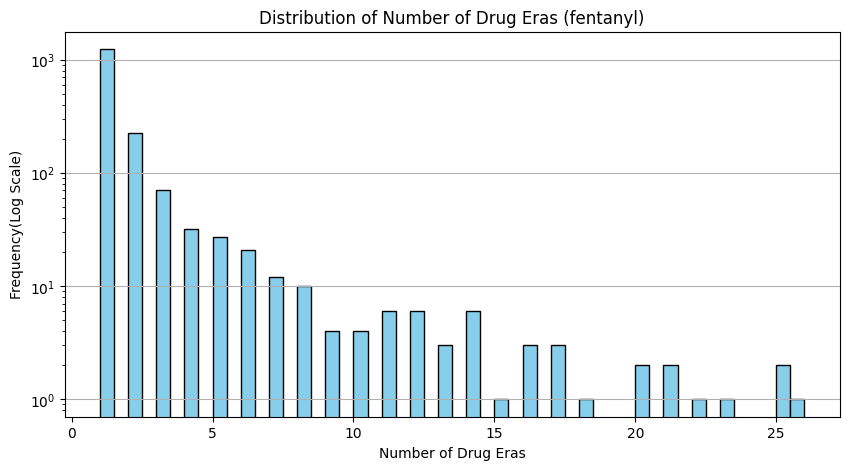

In [ ]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras["num_drug_era_id"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (fentanyl)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

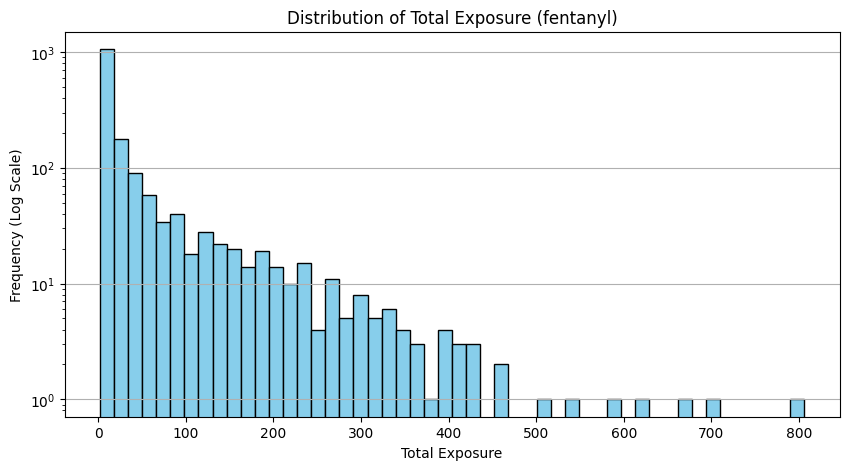

In [ ]:
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (fentanyl)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
plt.show()

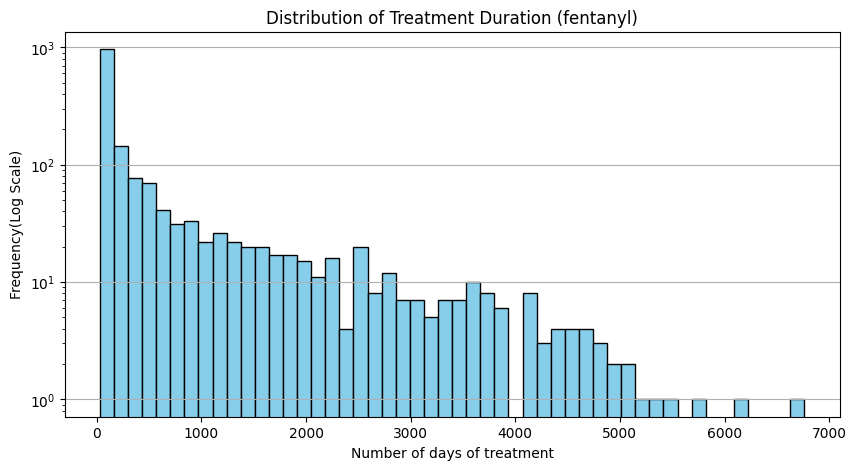

In [ ]:
# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras["total_duration"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Treatment Duration (fentanyl)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

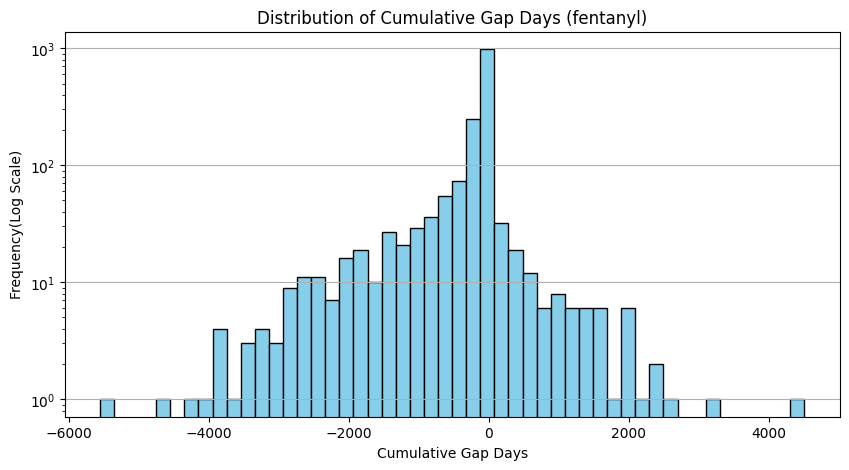

In [ ]:
# Visualize cumulative gap days
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras["cumulative_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Cumulative Gap Days (fentanyl)")
plt.xlabel("Cumulative Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

In [ ]:
fentanyl_eras.to_csv("omop_fentanyl_groupbyeid.csv", index=False)

In [ ]:
# 1. Load the phenotype CSV files into Pandas DataFrames
morphine_df = pd.read_csv("omop_morphine_groupbyeid.csv")
morphine_codeine_df = pd.read_csv("omop_morphine_codeine_groupbyeid.csv")
loperamide_df = pd.read_csv("omop_loperamide_groupbyeid.csv")
fentanyl_df = pd.read_csv("omop_fentanyl_groupbyeid.csv")


##### DataFrame formatting

Now run this for each drug

In [ ]:
participant = dataset["participant"]
df_participant = participant.retrieve_fields(names=["eid"], engine=dxdata.connect())
# Convert the Spark DataFrame 'participant' to a Pandas DataFrame
participant_df = df_participant.select("eid").toPandas()

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


In [ ]:
# 4. Ensure all 'eid' columns are of the same type (e.g., integer)
participant_df["eid"] = participant_df["eid"].astype(int)

# 5. Merge participant_df with morphine_codeine_df on 'eid', keeping all eids from participant_df
participant_df = participant_df.merge(
    morphine_codeine_df[
        [
            "eid",
            "num_drug_era_id",
            "total_exposure_counts",
            "total_duration",
            "cumulative_gap_days",
        ]
    ],
    on="eid",
    how="left",
)


In [50]:
display(participant_df.drop("eid", axis=1))
print(participant_df.notna().sum())  # Counts non-NaN values per column

,num_drug_era_id,total_exposure_counts,total_duration,cumulative_gap_days
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,1.0,1.0,29.0,0.0
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
502231,NaN,NaN,NaN,NaN
502232,1.0,1.0,29.0,0.0
502233,NaN,NaN,NaN,NaN
502234,NaN,NaN,NaN,NaN


eid                      502236
num_drug_era_id          103449
total_exposure_counts    103449
total_duration           103449
cumulative_gap_days      103449
dtype: int64


In [ ]:
# Set adherence_score_omop to None if total_exposure_counts is less than 2
# participant_df.loc[participant_df["total_exposure_counts"] < 2, "adherence_score_omop"] = None

In [52]:
display(participant_df.drop("eid", axis=1))

,num_drug_era_id,total_exposure_counts,total_duration,cumulative_gap_days
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,1.0,1.0,29.0,0.0
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
502231,NaN,NaN,NaN,NaN
502232,1.0,1.0,29.0,0.0
502233,NaN,NaN,NaN,NaN
502234,NaN,NaN,NaN,NaN


In [53]:
# Filter rows where num_drug_era_id is not NaN
filtered_df = participant_df[participant_df["num_drug_era_id"].notna()]

# Display the filtered DataFrame
print("Rows where num_drug_era_id is not NaN:")
display(filtered_df.drop("eid", axis=1))

Rows where num_drug_era_id is not NaN:


,num_drug_era_id,total_exposure_counts,total_duration,cumulative_gap_days
2,1.0,1.0,29.0,0.0
7,4.0,5.0,3173.0,3043.0
12,4.0,11.0,2362.0,2057.0
17,3.0,4.0,206.0,90.0
18,2.0,17.0,383.0,86.0
...,...,...,...,...
502220,1.0,1.0,29.0,0.0
502222,2.0,2.0,1730.0,1672.0
502227,1.0,2.0,82.0,24.0
502232,1.0,1.0,29.0,0.0


In [ ]:
# Set the 'eid' column as the index
participant_df.set_index("eid", inplace=True)

# Insert 'FID' and 'IID' as the first two columns using the index
participant_df.insert(0, "FID", participant_df.index)
participant_df.insert(1, "IID", participant_df.index)

##### Export and upload DataFrame

In [ ]:
# Save the result as a TSV file
participant_df.to_csv(
    "morphine_codeine_phenotype.QT.tsv", sep="\t", index=False, na_rep="NA"
)

In [57]:
! dx upload "morphine_codeine_phenotype.QT.tsv" --path /WGS_Lucia/Data/phenotypes/

FileNotFoundError: [Errno 2] No such file or directory: 'morphine_codeine.phenotype.QT.tsv'
